In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Activation, Dropout
from tensorflow.keras.utils import normalize
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.metrics import Precision, Recall, SparseCategoricalAccuracy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
from random import shuffle
import numpy as np
import os
import pickle

In [2]:
def load_pickle(file):
    filename = '../input/'+file+'.pickle'
    with open(filename, 'rb') as p:
        return pickle.load(p)
    
X_train = load_pickle('X_train')
y_train = load_pickle('y_train')
X_test = load_pickle('X_test')
y_test = load_pickle('y_test')

#split 10% of train data into validation


In [3]:
# randomize the data before training
def shuffle_data(X,y):
    zipped_train = list(zip(X,y))
    shuffle(zipped_train)
    X, y = zip(*zipped_train)
    return np.array(X),np.array(y)

X_train, y_train = shuffle_data(X_train, y_train)

X_val,y_val = X_train[:520],y_train[:520] 
X_train,y_train = X_train[520:], y_train[520:]

In [4]:
bsize = 64
epochs = 50

aug = ImageDataGenerator(rotation_range=20,	zoom_range=0.3,	vertical_flip=True)
#build model using keras

model = Sequential()

model.add(Conv2D(32, (3,3), input_shape = X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(128, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = [SparseCategoricalAccuracy()])

hist = model.fit_generator(aug.flow(X_train,y_train, batch_size = bsize), 
                          steps_per_epoch=len(X_train) // bsize,
                          epochs = epochs,
                          validation_data= (X_val, y_val))

model.save('pneumonia_train.h5')



Epoch 1/50
73/73 [==============================] - 19s 255ms/step - loss: 1.0478 - sparse_categorical_accuracy: 0.4802 - val_loss: 1.0480 - val_sparse_categorical_accuracy: 0.4365
Epoch 2/50
73/73 [==============================] - 18s 246ms/step - loss: 0.8941 - sparse_categorical_accuracy: 0.5884 - val_loss: 0.7922 - val_sparse_categorical_accuracy: 0.6846
Epoch 3/50
73/73 [==============================] - 17s 232ms/step - loss: 0.8101 - sparse_categorical_accuracy: 0.6358 - val_loss: 0.7924 - val_sparse_categorical_accuracy: 0.6904
Epoch 4/50
73/73 [==============================] - 17s 233ms/step - loss: 0.7340 - sparse_categorical_accuracy: 0.6822 - val_loss: 0.7099 - val_sparse_categorical_accuracy: 0.6885
Epoch 5/50
73/73 [==============================] - 16s 217ms/step - loss: 0.7105 - sparse_categorical_accuracy: 0.6919 - val_loss: 0.6864 - val_sparse_categorical_accuracy: 0.7346
Epoch 6/50
73/73 [==============================] - 15s 209ms/step - loss: 0.6772 - sparse_cate

In [5]:
# model = load_model('best_model.hdf5')
train_acc = model.evaluate(X_train,y_train ,verbose = False)
test_acc = model.evaluate(X_test, y_test, verbose = False)
yhat_classes = model.predict_classes(X_test, verbose=0)

In [6]:
print(f'Training: Accuracy = {train_acc[1]}')
print(f'Test: Accuracy = {test_acc[1]}\n')

print(f'Training: Loss = {train_acc[0]}')
print(f'Test: Loss = {test_acc[0]}\n')


Training: Accuracy = 0.8204584121704102
Test: Accuracy = 0.8317307829856873

Training: Loss = 0.42430439829219174
Test: Loss = 0.5255401516572024



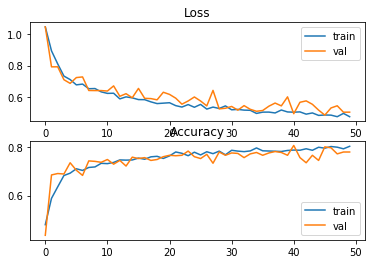

In [7]:
#PLot graphs for loss and accuracy yduring training

# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(hist.history['sparse_categorical_accuracy'], label='train')
plt.plot(hist.history['val_sparse_categorical_accuracy'], label='val')
plt.legend()
plt.show()

Accuracy: 0.831731
Precision: 0.831731
Recall: 0.831731
F1 score: 0.831731
Confusion Matrix:
[[176  17  41]
 [  3 233   6]
 [  0  38 110]]


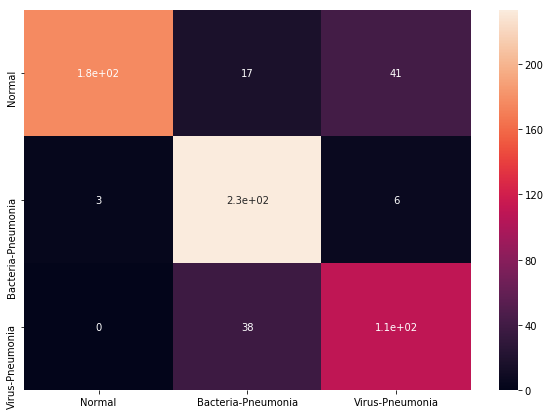

In [8]:
# predict classes for test set

# reduce to 1d array
# yhat_classes = yhat_classes[:, 0]
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes, average = 'micro')
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes, average = 'micro')
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes, average = 'micro')
print('F1 score: %f' % f1)

# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(f'Confusion Matrix:\n{matrix}')

categories = ['Normal', 'Bacteria-Pneumonia', 'Virus-Pneumonia']
df_cm = pd.DataFrame(matrix, index = [i for i in categories],
                  columns = [i for i in categories])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot = True)

In [9]:
model = load_model('pneumonia_train.h5')
model_eval = model.evaluate(X_test, y_test, verbose = 0)

In [10]:
print(model_eval)

[0.5255401516572024, 0.8317308]
